# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper
from time import time

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Define transformations
    # I need only to resize and convert to tensor, because the data are already been adapted.
    custom_transform = transforms.Compose([transforms.Resize(image_size),
                                           transforms.ToTensor()])
    
    data = datasets.ImageFolder(data_dir, transform = custom_transform)

    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle = True, num_workers=0)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32  # 64 or 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

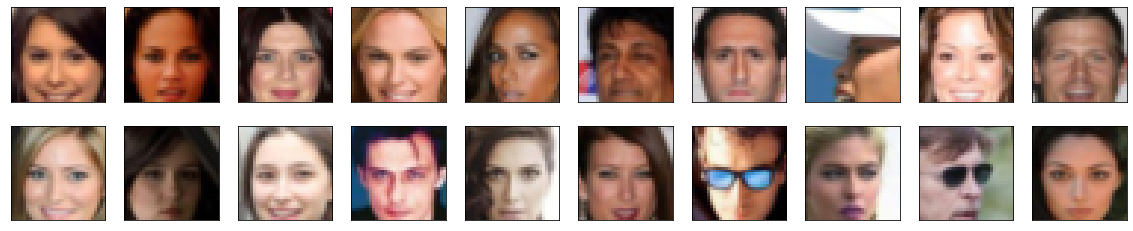

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    scale = feature_range[1] - feature_range[0]
    offset = feature_range[0]
    
    return x*scale + offset


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    # "conv_dim" is the output dimension of the first convolutional layer;
    # that is, the number of filters/kernels you have in the first layer (3 inputs, RGB, and conv_dim outputs)
    
    def __init__(self, conv_dim=32, img_size=32):
        super(Discriminator, self).__init__()
        
        # Configuration parameters
        kernel_size=4
        n_conv_layers = 4  # Only used for definition of fc_in
        fc_in = int(conv_dim * 2**(n_conv_layers-1) * (img_size/(2**n_conv_layers))**2)
        
        # Dense or fully connected layer
        self.fc = nn.Linear(fc_in, 1) # 32 x 32
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = conv_dim,
                               kernel_size = kernel_size,
                               stride = 2,
                               padding = 1,
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels = conv_dim,
                               out_channels = 2*conv_dim,
                               kernel_size = kernel_size,
                               stride = 2,
                               padding = 1,
                               bias=False)
        self.conv3 = nn.Conv2d(in_channels = 2*conv_dim,
                               out_channels = 4*conv_dim,
                               kernel_size = kernel_size,
                               stride = 2,
                               padding = 1,
                               bias=False)
        self.conv4 = nn.Conv2d(in_channels = 4*conv_dim,
                               out_channels = 8*conv_dim,
                               kernel_size = kernel_size,
                               stride = 2,
                               padding = 1,
                               bias=False)
        
        # Batchnorm layers. Not for the first convolutional layer.
        self.bnorm2 = nn.BatchNorm2d(2*conv_dim)
        self.bnorm3 = nn.BatchNorm2d(4*conv_dim)
        self.bnorm4 = nn.BatchNorm2d(8*conv_dim)
        

    def forward(self, x):
        # all hidden layers + leaky relu activation
        # in: batch x 3 x img_size x img_size  -->  b x 3 x 32 x 32
        batch_size = x.size(0)
        out = F.leaky_relu(self.conv1(x), negative_slope=0.2)  # b x conv_dim x img_size/2 x img_size/2  -->  b x 32 x 16 x 16
        out = F.leaky_relu(self.bnorm2(self.conv2(out)), negative_slope=0.2)  # b x 64 x 8 x 8
        out = F.leaky_relu(self.bnorm3(self.conv3(out)), negative_slope=0.2)  # b x 128 x 4 x 4
        out = F.leaky_relu(self.bnorm4(self.conv4(out)), negative_slope=0.2)  # b x 256 x 2 x 2  ==  b x 1024
        
        # flatten
        out = out.contiguous().view(batch_size, -1)  # b x 1024
        
        # final output layer without sigmoid activation function
        logits = self.fc(out)  # b x 1
        return logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    # conv_dim is the input dimension of the last transposed convolution layer;
    # that is, the output of this layer has to be 3 due to RGB; but the input is arbitrary;
    # well, here it will be conv_dim. The design of the forward pass is done from the end
    # to the beginning calculating the dimensions (see comments in the code)
    
    def __init__(self, z_size, conv_dim=32, img_size=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function

        # Configuration parameters
        kernel_size=4
        self.conv_dim = conv_dim

        n_conv_layers = 4  # Only used for definition of fc_out and i_s_fco. See also flaten in forward pass.
        self.n_conv_layers = n_conv_layers
        fc_out = int(conv_dim * 2**(n_conv_layers-1) * (img_size/(2**n_conv_layers))**2)
        self.i_s_fco = int(img_size/ 2**n_conv_layers) # image size on fully connected layer output

        # Linear layer
        self.fc = nn.Linear(z_size, fc_out)
        
        # Transpose convolutional layers
        self.tconv1 = nn.ConvTranspose2d(in_channels = conv_dim * 8,
                                        out_channels = conv_dim * 4,
                                        kernel_size = 4,
                                        stride = 2,
                                        padding = 1,
                                        bias = False)
        self.tconv2 = nn.ConvTranspose2d(in_channels = conv_dim * 4,
                                        out_channels = conv_dim * 2,
                                        kernel_size = kernel_size,
                                        stride = 2,
                                        padding = 1,
                                        bias = False)
        self.tconv3 = nn.ConvTranspose2d(in_channels = conv_dim * 2,
                                        out_channels = conv_dim,
                                        kernel_size = kernel_size,
                                        stride = 2,
                                        padding = 1,
                                        bias = False)
        self.tconv4 = nn.ConvTranspose2d(in_channels = conv_dim,
                                        out_channels = 3,
                                        kernel_size = kernel_size,
                                        stride = 2,
                                        padding = 1,
                                        bias = False)
        
        # Batchnorm layers
        self.bnorm1 = nn.BatchNorm2d(conv_dim * 4)
        self.bnorm2 = nn.BatchNorm2d(conv_dim * 2)
        self.bnorm3 = nn.BatchNorm2d(conv_dim)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # in: batch x z_size.  b x 100
        b = x.size(0)
        out = self.fc(x)  # b x (conv_dim * 2**(num_layers-1))  -->  b x (32*32) = b x 1024
        out = out.contiguous().view(b, -1, self.i_s_fco, self.i_s_fco) # b x conv_dim*8 x img_size/16 x img_size/16  --> b x 256 x 2 x 2
        out = F.relu(self.bnorm1(self.tconv1(out)))  # b x conv_dim*4 x img_size/8 x img_size/8  ==  b x 128 x 4 x 4
        out = F.relu(self.bnorm2(self.tconv2(out)))  # b x conv_dim*2 x img_size/4 x img_size/4  ==  b x 64 x 8 x 8
        out = F.relu(self.bnorm3(self.tconv3(out)))  # b x conv_dim x img_size/2 x img_size/2  ==  b x 32 x 16 x 16
        out = torch.tanh(self.tconv4(out))  # batch x 3 x img_size x img_size  ==  b x 3 x 32 x 32
        
        return out    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Variable assignation
    mean = 0
    stdev = 0.02
    init_type = 'normal'
    
    # Weights initialization. Prepared for others than normal.
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            nn.init.normal_(m.weight.data, mean, stdev)
        elif init_type == 'xavier':
            nn.init.xavier_normal_(m.weight.data, gain=init_gain)
        elif init_type == 'kaiming':
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            nn.init.orthogonal_(m.weight.data, gain=init_gain)
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, stdev)
        nn.init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size, img_size=32):
    # define discriminator and generator
    D = Discriminator(d_conv_dim, img_size)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim, img_size=img_size)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size, img_size)

Discriminator(
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    # move labels to GPU if available  
    if train_on_gpu:
        labels = labels.cuda()
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# Parameters
lr_d = 0.0002
lr_g = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=200):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()

            # 1.1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 1.2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()

            # 2.1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    torch.save(samples, 'train_samples.pkl')
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
start_time = time()
losses = train(D, G, n_epochs=n_epochs)
elapsed_time = time() - start_time
print('Elapsed time: {:.2f}'.format(elapsed_time))

Epoch [    1/   20] | d_loss: 1.3625 | g_loss: 2.3896
Epoch [    1/   20] | d_loss: 0.7160 | g_loss: 2.6415
Epoch [    1/   20] | d_loss: 0.8096 | g_loss: 1.9222
Epoch [    1/   20] | d_loss: 1.1026 | g_loss: 1.2172
Epoch [    2/   20] | d_loss: 0.7751 | g_loss: 2.2401
Epoch [    2/   20] | d_loss: 0.7736 | g_loss: 2.2159
Epoch [    2/   20] | d_loss: 0.8660 | g_loss: 2.1211
Epoch [    2/   20] | d_loss: 0.9785 | g_loss: 1.9589
Epoch [    3/   20] | d_loss: 1.1150 | g_loss: 2.8922
Epoch [    3/   20] | d_loss: 0.8321 | g_loss: 2.4469
Epoch [    3/   20] | d_loss: 1.0128 | g_loss: 2.6445
Epoch [    3/   20] | d_loss: 0.9522 | g_loss: 3.1437
Epoch [    4/   20] | d_loss: 0.7397 | g_loss: 1.8849
Epoch [    4/   20] | d_loss: 0.9033 | g_loss: 1.9433
Epoch [    4/   20] | d_loss: 0.9961 | g_loss: 2.1568
Epoch [    4/   20] | d_loss: 0.7057 | g_loss: 2.2564
Epoch [    5/   20] | d_loss: 0.8928 | g_loss: 1.8227
Epoch [    5/   20] | d_loss: 0.8558 | g_loss: 1.2497
Epoch [    5/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

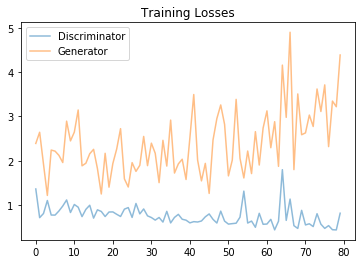

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, img_size=32):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size,3)))

In [22]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')

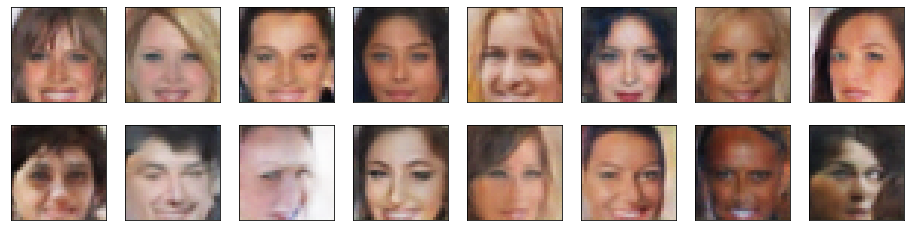

In [23]:
_ = view_samples(-1, samples, img_size)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
The dataset is biased, so the first improvement I would implement would be to use a much larger dataset with greater variability in terms of race, color, gender, accessories, hair style, etc.

On the other hand, since larger models have the opportunity to learn more features, I'd implement a deeper model with more convolutional layers. I wouldn't resize the images to 32x32 because of its quality loss. In fact, I am going to try how it works with size 64x64 below.

Other ways to optimize the results could be as follows:

* Try to use SGD optimizer in the discriminator.
* Train for larger epochs and see the results.
* Modify some training parameters such as learning rate and beta.
* Use some of the techniques described in the paper "Improved techniques for training GANs" https://arxiv.org/pdf/1606.03498.pdf. The most obviuos option in this case is "One-sided label smoothing". In fact, its effect can be explored in this code just by selecting smooth=True/False in the definition of the function called real_loss.


Now I repeat the simulation with img_size = 64. The network is trained for 50 epochs and, at the end, results are showed every 10 epochs

In [27]:
# Same model without changing the original image size
img_size = 64

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# Build network
D, G = build_network(d_conv_dim, g_conv_dim, z_size, img_size)

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

# Parameters
lr_d = 0.0002
lr_g = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

# set number of epochs 
n_epochs = 50

# call training function
start_time = time()
losses = train(D, G, n_epochs=n_epochs)
elapsed_time = time() - start_time
print('Elapsed time: {:.2f}'.format(elapsed_time))

Discriminator(
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (tconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv

Epoch [   32/   50] | d_loss: 0.3475 | g_loss: 5.1769
Epoch [   32/   50] | d_loss: 0.3548 | g_loss: 4.7551
Epoch [   32/   50] | d_loss: 0.3488 | g_loss: 4.7790
Epoch [   33/   50] | d_loss: 0.3562 | g_loss: 4.6223
Epoch [   33/   50] | d_loss: 0.4365 | g_loss: 3.4838
Epoch [   33/   50] | d_loss: 0.3715 | g_loss: 4.4889
Epoch [   33/   50] | d_loss: 0.6045 | g_loss: 1.7250
Epoch [   34/   50] | d_loss: 0.3921 | g_loss: 4.6991
Epoch [   34/   50] | d_loss: 0.3843 | g_loss: 4.8383
Epoch [   34/   50] | d_loss: 0.3690 | g_loss: 4.0469
Epoch [   34/   50] | d_loss: 1.1117 | g_loss: 1.2532
Epoch [   35/   50] | d_loss: 0.4713 | g_loss: 3.6612
Epoch [   35/   50] | d_loss: 0.4311 | g_loss: 4.1385
Epoch [   35/   50] | d_loss: 0.3606 | g_loss: 3.8580
Epoch [   35/   50] | d_loss: 0.3646 | g_loss: 3.8514
Epoch [   36/   50] | d_loss: 0.4742 | g_loss: 4.2371
Epoch [   36/   50] | d_loss: 0.3605 | g_loss: 4.2721
Epoch [   36/   50] | d_loss: 0.3704 | g_loss: 4.2212
Epoch [   36/   50] | d_loss

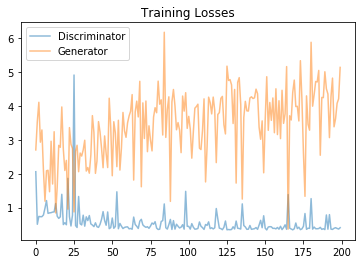

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

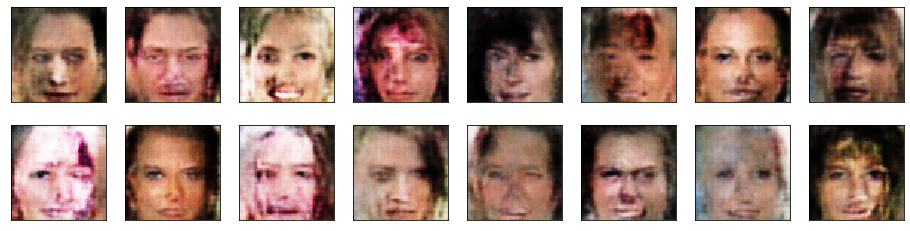

In [32]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-50, samples, img_size)

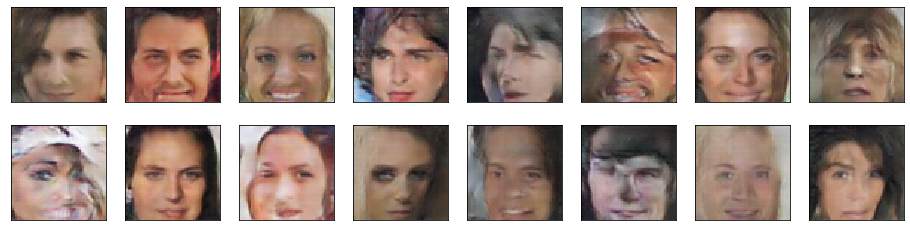

In [33]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-40, samples, img_size)

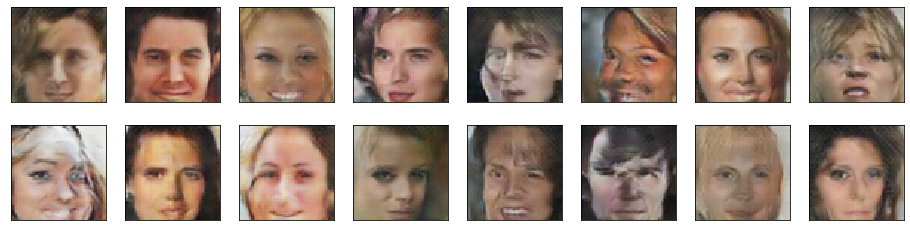

In [34]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-30, samples, img_size)

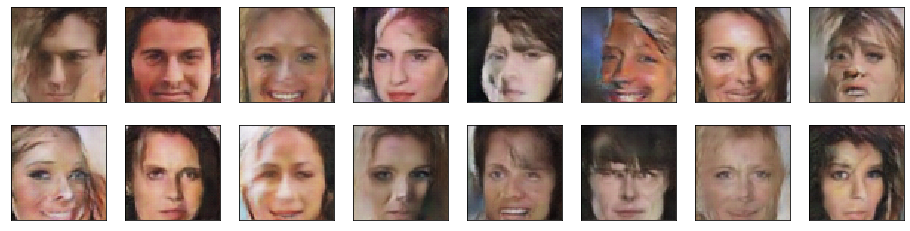

In [35]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-20, samples, img_size)

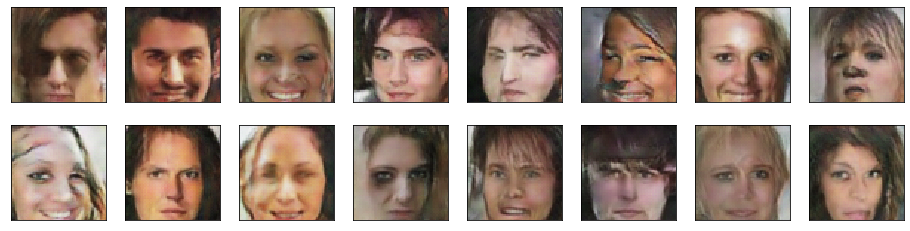

In [36]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-10, samples, img_size)

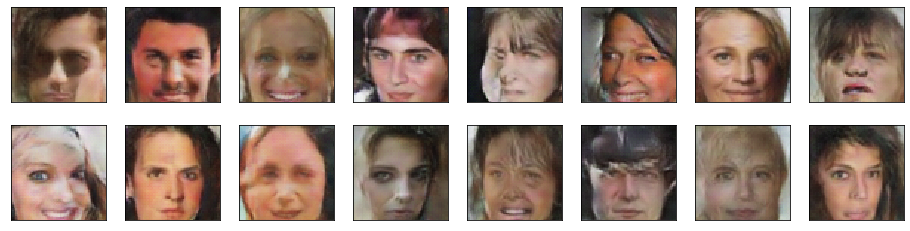

In [37]:
# Load samples from generator, taken while training
samples = torch.load('train_samples.pkl')
_ = view_samples(-1, samples, img_size)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.